In [1]:
!pip install scvi-tools -U
!pip install scanpy
!pip3 install leidenalg
!pip install git+https://github.com/theislab/scvelo
!pip install cellrank

  Cloning https://github.com/theislab/scvelo to /tmp/pip-req-build-euf6lymm
  Running command git clone -q https://github.com/theislab/scvelo /tmp/pip-req-build-euf6lymm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
#import sys
#from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
#import anndata
import seaborn as sns
import scvi
import scvelo as scv
import cellrank as cr

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##Restart for trajectory
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/datasets')
gca = sc.read_h5ad('gca_scVI.h5ad')
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data')
model = scvi.model.SCVI.load("full_scVI_model_v4/", gca, use_gpu=True)

In [ ]:
#add combined annotation

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/stats')
blood_anno = pd.read_csv('blood_clustering.csv', index_col = 0)
tissue_anno = pd.read_csv('tissue_clustering.csv', index_col = 0)

blood_anno.columns = ['anno']
tissue_anno.columns = ['anno']

blood_anno['anno'] = blood_anno.anno.astype(str) + '_blood'
tissue_anno['anno'] = tissue_anno.anno.astype(str) + '_tissue'

anno = blood_anno.append(tissue_anno)

gca.obs = gca.obs.merge(anno, how = 'left', left_index = True, right_index = True)

gca.obs.anno = gca.obs.anno.astype('category')

In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/loom_files_run2')
files = os.listdir()
files.remove('cache')

In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/loom_files')

loom_files = scv.read(files[0], cache=True)
loom_files.var_names_make_unique()
loom_files = loom_files[:, loom_files.var_names.isin(gca.var.index)]

a = pd.DataFrame(loom_files.obs.index.str.split(':').tolist(),
                                 columns = ['donor','barcode'])
a.barcode = a.barcode.str[:-1]
loom_files.obs.index = a.barcode + '-' + a.donor.str[:-4]

In [ ]:
for i in range(1, len(files)):
    temp = scv.read(files[i], cache=True)
    temp.var_names_make_unique()
    temp = temp[:, temp.var_names.isin(gca.var.index)]

    a = pd.DataFrame(temp.obs.index.str.split(':').tolist(),
                                 columns = ['donor','barcode'])
    a.barcode = a.barcode.str[:-1]
    temp.obs.index = a.barcode + '-' + a.donor.str[:-4]
    loom_files = loom_files.concatenate(temp, index_unique = None)

In [ ]:
loom_files.obs.index = loom_files.obs.index.str.replace('GCA54_1','GCA54_T1')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA54_2','GCA54_T2')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA54_3','GCA54_B1')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA54_4','GCA54_B2')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA55_1','GCA55_T1')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA55_2','GCA55_T2')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA55_3','GCA55_B1')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA55_4','GCA55_B2')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA70_1','GCA70_T1')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA70_2','GCA70_T2')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA70_3','GCA70_B1')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA70_4','GCA70_B2')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA47_1','GCA47_T1')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA47_2','GCA47_T2')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA47_3','GCA47_B1')
loom_files.obs.index = loom_files.obs.index.str.replace('GCA47_4','GCA47_B2')

In [ ]:
gca = scv.utils.merge(gca, loom_files)

In [ ]:
gca = gca[gca.obs.auto_prd == 'False',:]

In [ ]:
vsmc = gca[gca.obs.anno.isin(['VSMC_tissue', 'Transitional_tissue', 'MyoFB_tissue']),:]

In [ ]:
vsmc.X = vsmc.layers['counts']

In [ ]:
#scv.pp.filter_and_normalize(tissue)
sc.pp.neighbors(vsmc, n_pcs=30, n_neighbors=30, use_rep = 'X_scVI')
scv.pp.moments(vsmc, n_pcs=None, n_neighbors=None, use_rep = 'X_scVI')

Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
scv.tl.velocity(vsmc, mode="dynamical")
scv.tl.velocity_graph(vsmc)

computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/4 cores)


  0%|          | 0/10340 [00:00<?, ?cells/s]

    finished (0:00:23) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:
new_colors = np.array(vsmc.uns['anno_colors'])

new_colors[[0]] = '#2c7c94'  # VSMC_tissue
new_colors[[1]] = '#343c24'  # Transitional_tissue
new_colors[[2]] = '#fbe45b'  # MyoFB_tissue

vsmc.uns['anno_colors'] = new_colors

In [ ]:
scv.tl.recover_dynamics(vsmc)

recovering dynamics (using 1/4 cores)


  0%|          | 0/243 [00:00<?, ?gene/s]

    finished (0:04:19) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [ ]:
scv.tl.terminal_states(vsmc)
scv.tl.latent_time(vsmc)

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


In [4]:
###Restart for plotting


os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/datasets')
vsmc = sc.read_h5ad('vsmc.h5ad')

In [5]:
new_colors = np.array(vsmc.uns['anno_colors'])

new_colors[[0]] = '#fbe45b'  # MyoFB_tissue
new_colors[[1]] = '#343c24'  # Transitional_tissue
new_colors[[2]] = '#2c7c94'  # VSMC_tissue

vsmc.uns['anno_colors'] = new_colors

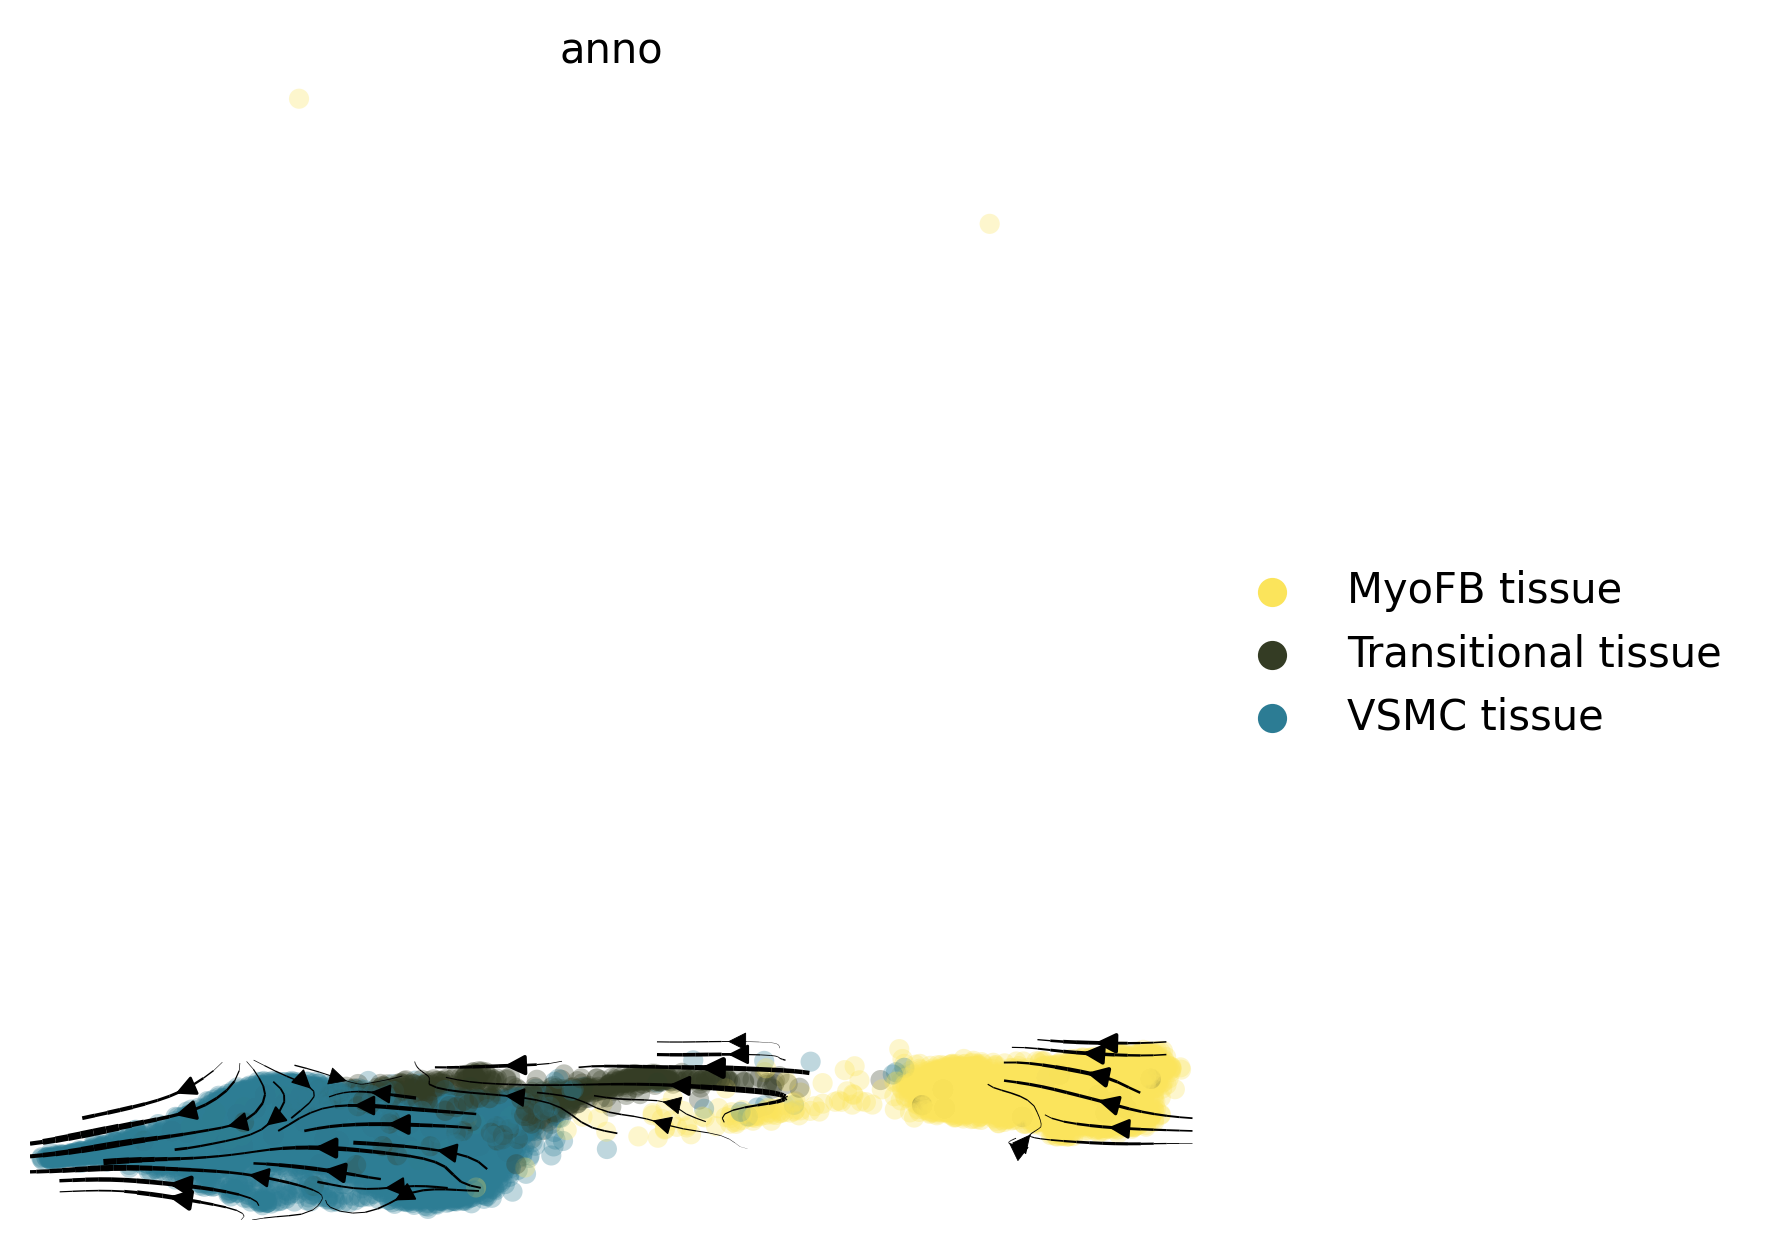

In [6]:
plt.rcParams['figure.figsize'] = [5, 5]

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

scv.pl.velocity_embedding_stream(vsmc, basis='X_umap', 
                                 color = 'anno', 
                                 legend_loc = 'right margin', 
#                                 smooth=0.8, 
#                                 min_mass=4,
                                 
                                 density = 3,
                                 dpi = 300, 
 #                                save = 'velocity_plot.png'
                                 )

saving figure to file ./figures/scvelo_umap_root_cells.png


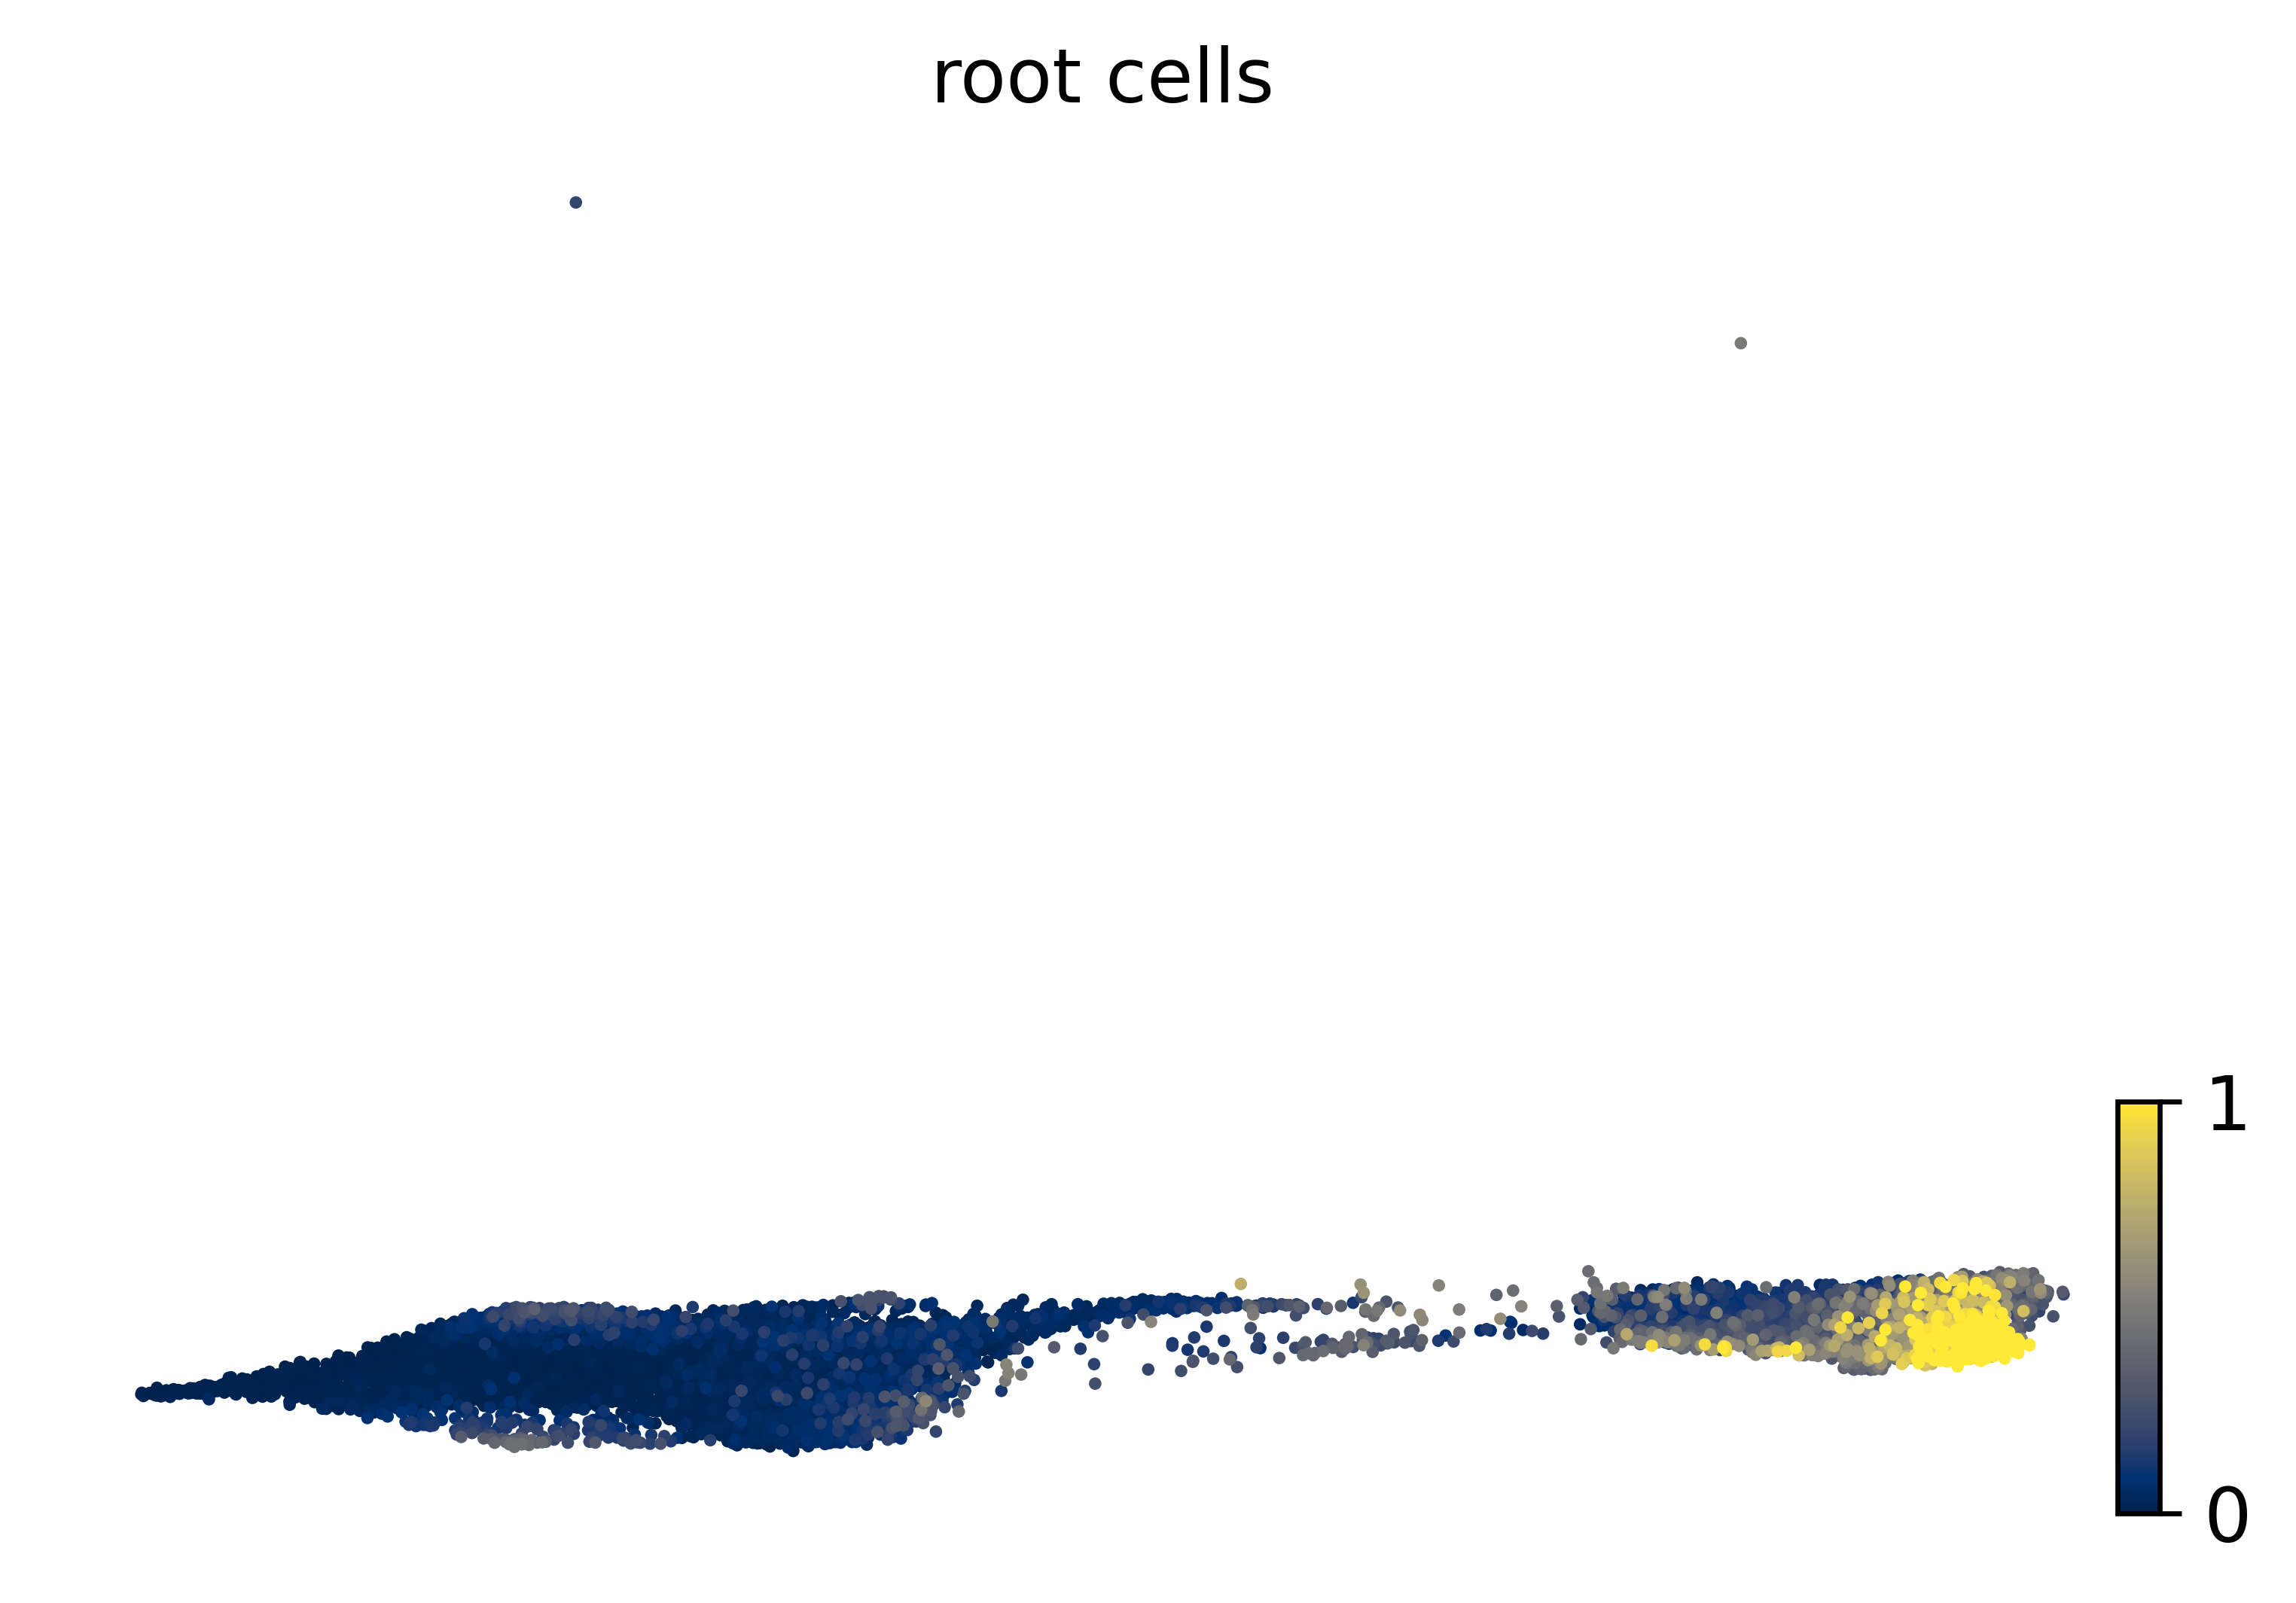

In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')
scv.pl.scatter(vsmc, color='root_cells', color_map='cividis', dpi = 300, 
              save = 'umap_root_cells.png'
               )

saving figure to file ./figures/scvelo_umap_end_cells.png


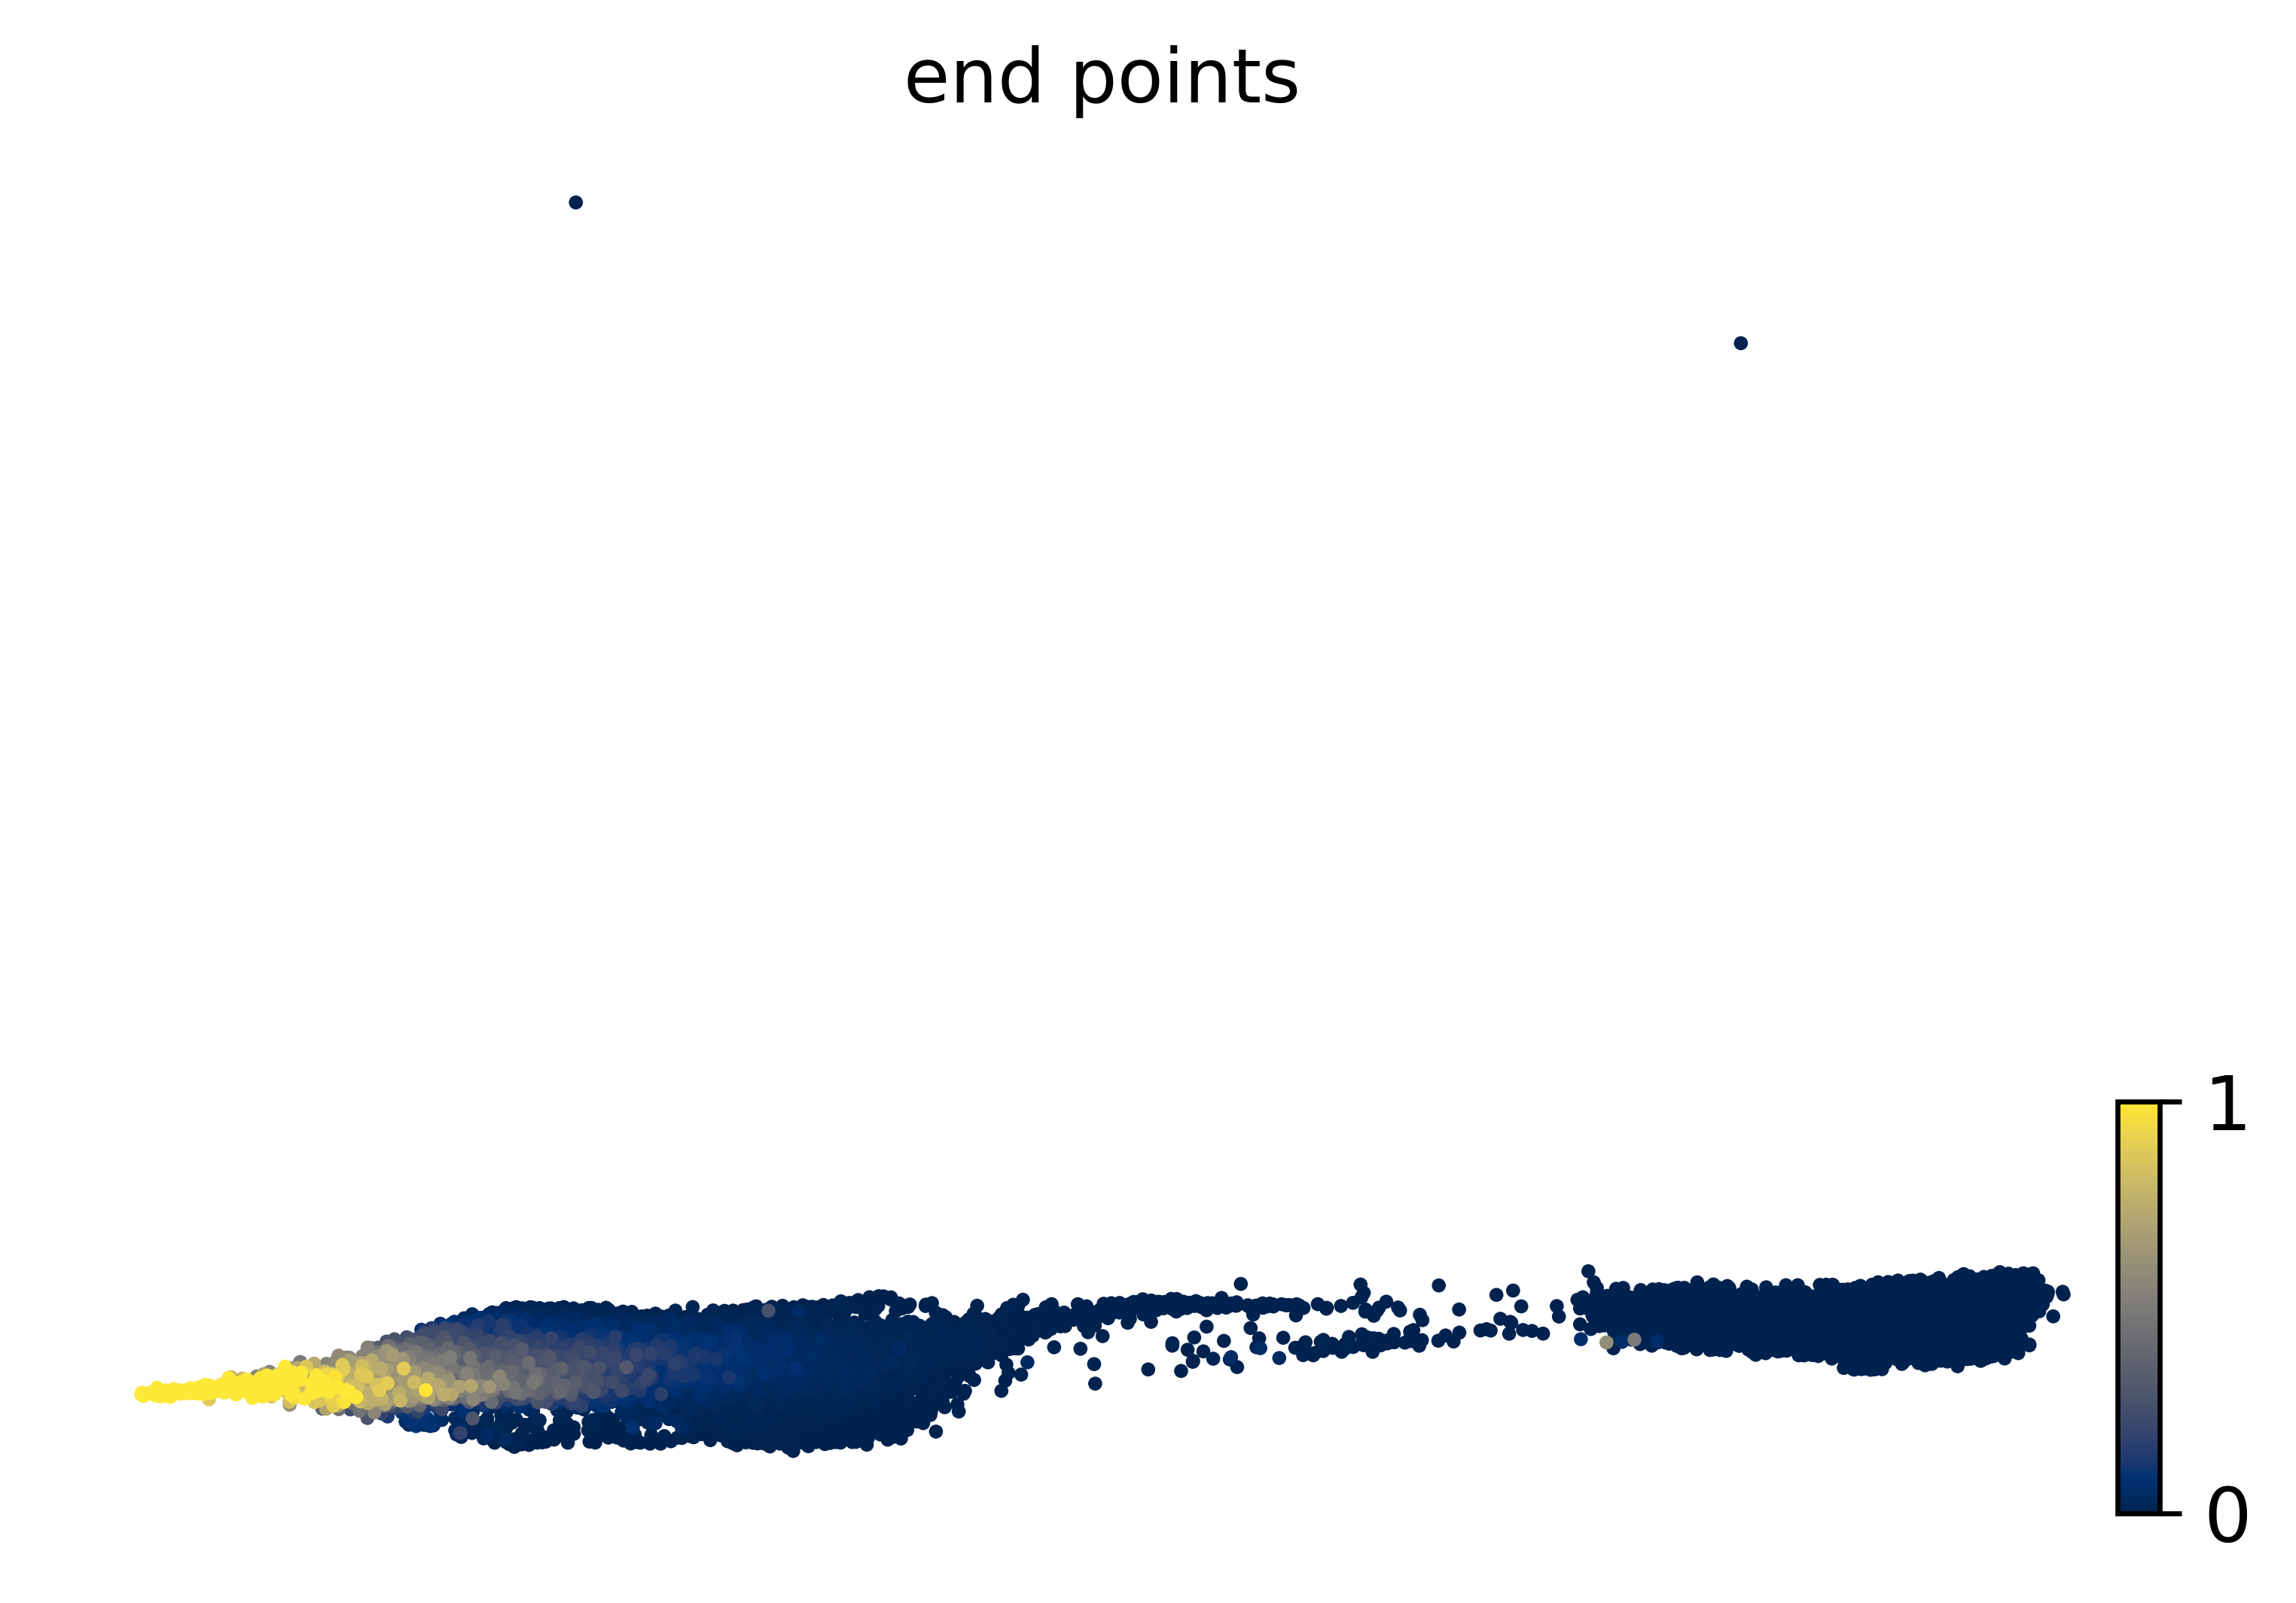

In [ ]:
scv.settings.set_figure_params('scvelo')
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

scv.pl.scatter(vsmc, color='end_points', color_map='cividis', size=20, dpi = 300, 
               save = 'umap_end_cells.png'
               )

In [ ]:
scv.tl.rank_velocity_genes(vsmc, groupby='anno', min_corr=.3)

df = scv.DataFrame(vsmc.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes
    finished (0:00:04) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,MyoFB_tissue,Transitional_tissue,VSMC_tissue
0,CST3,DKK3,CALD1
1,PDGFRL,BGN,RYR2
2,IGF1,FBN1,CRYAB
3,STON2,THBS2,A2M
4,ZNF385B,TNXB,DMD


computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)
saving figure to file ./figures/scvelo_umap_latent_time_cells.pdf


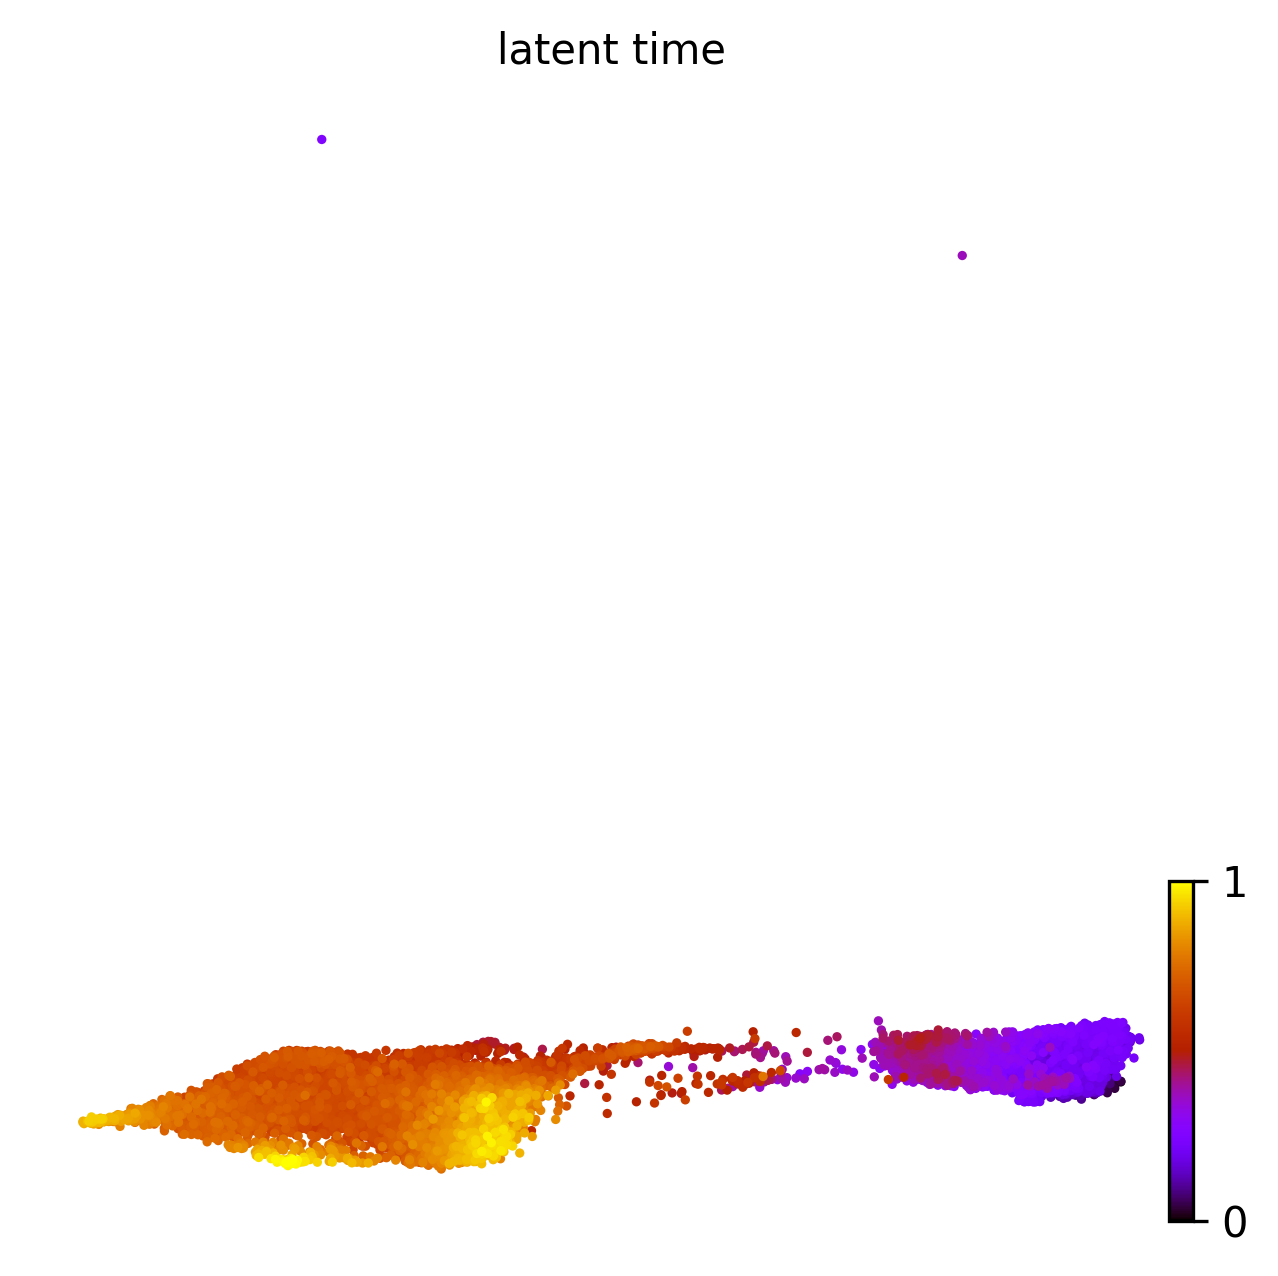

In [ ]:
scv.tl.latent_time(vsmc)
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')
scv.pl.scatter(vsmc, color='latent_time', color_map='gnuplot', 
               size=20, 
               dpi = 300, 
              save = 'umap_latent_time_cells.pdf'
            )

In [ ]:
test = vsmc[vsmc.obs.latent_time.between(0, 1.0),:]

saving figure to file ./figures/scvelo_heatmap_latent_time_heatmap.png


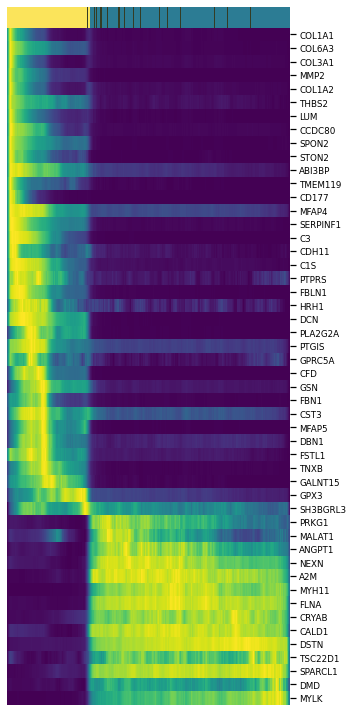

In [ ]:
top_genes = vsmc.var['fit_likelihood'].sort_values(ascending=False).index[:50]
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')
scv.pl.heatmap(vsmc, var_names=top_genes, sortby='latent_time', col_color='anno', n_convolve=200, figsize = [5,10], 
               font_scale = 0.8, save = 'latent_time_heatmap.png')

In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/datasets')
vsmc.write('vsmc.h5ad', compression = 'gzip')